In [44]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import random
import math
import cv2
import os
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

from tensorflow import keras
from keras import ops

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (
    Input, Dense, Flatten, Dropout, Embedding, LayerNormalization,
    MultiHeadAttention, Add, Conv2D, MaxPooling2D, GlobalAveragePooling2D,
    BatchNormalization, Activation
)
from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    device = '/GPU:0'  # Use the first GPU if available
else:
    device = '/CPU:0'  # Use CPU if no GPU is available

print("Using device:", device)

Using device: /CPU:0


In [3]:
class DatasetParser():
    def __init__(self, root_dir, images_dir, labels_csv, task_type="binary"):
        
        '''
        parameters:
                    root_dir: The path to root directory which contains a labels csv file and images_dir
                    images_dir: The name of the directory containing the images
                    labels_csv: The name of the csv containing information of the labels
                    task_type: Either binary or multiclass
        '''
        
        self.image_paths = sorted(glob.glob(os.path.join(root_dir, images_dir,"*.png")))
        self.labels_df = self._labels_by_task(task_type=task_type, root_dir=root_dir, labels_csv=labels_csv)
        self.task_type = task_type
        
        if task_type is "binary":
            self.labels = ['normal', 'abnormal']
        else:
            self.labels = ['Cardiomegaly','Emphysema','Effusion',
                           'Hernia','Nodule','Pneumothorax','Atelectasis',
                           'Pleural_Thickening','Mass','Edema','Consolidation',
                           'Infiltration','Fibrosis','Pneumonia', 'No Finding']
    
    def visualize_random_images(self, num_images=1, label=None, display_label=False):
        
        '''
        parameters:
                    num_images: The number of images to display
                    label: If none then random images will be displayed.
                           Else, display images with a particular label
                    display_label: Decides if the label needs to be displayed
        '''
        
        fig = plt.figure(figsize=(20,20))
        fig.tight_layout(pad=10.0)
        if label is None:
            idxs = random.sample(range(len(self.image_paths)), num_images)
        else:
            idxs = [idx for idx in range(len(self.labels_df['Label'])) if label in self.labels_df['Label'][idx]]
            if len(idxs) < num_images:
                num_images = len(idxs)
            else:
                idxs = random
                (idxs, num_images)
                
        num_rows = math.ceil(np.sqrt(num_images))
        num_cols = math.ceil(num_images/num_rows)
        
        for i in range(num_images):
            img = cv2.imread(self.image_paths[idxs[i]])
            plt.subplot(num_rows, num_cols, i+1)
            if display_label:
                plt.gca().set_title(self.labels_df['Label'][idxs[i]],wrap=True)
            plt.axis('off')
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
    def _labels_by_task(self,task_type="binary", root_dir=None, labels_csv=None):
        '''
            Helper method for modifying the labels dataframe with respect to the required task.
            
            Returns: New labels dataframe with columns ('Id', 'Labels') 
        '''
        
        labels_df = pd.read_csv(os.path.join(root_dir, labels_csv))
        new_labels_df = pd.DataFrame()
        new_labels_df['Id'] = labels_df['Image Index'].copy()
        
        if task_type is "binary":
            new_labels_df.loc[labels_df['Finding Labels'] == "No Finding",'Label'] = "normal"
            new_labels_df.loc[labels_df['Finding Labels'] != "No Finding", 'Label'] = "abnormal"
        else:
            new_labels_df['Label'] = labels_df['Finding Labels'].apply(lambda val: val.split('|'))
        
        del labels_df
        
        return new_labels_df
    
    def explore_class_imbalance(self):
        '''
            Returns a plot of class frequencies along with an indication of class imbalance
        '''
        label_counts = [0 for i in range(len(self.labels))]
        
        for label in self.labels_df['Label']:
            if self.task_type == "binary":
                label_counts[self.labels.index(label)] += 1
            else:
                for element in label:
                    label_counts[self.labels.index(element)] += 1
        
        fig, ax1 = plt.subplots(1,1,figsize = (6, 6))
        ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
        ax1.set_xticks(np.arange(len(label_counts))+0.5)
        _ = ax1.set_xticklabels(self.labels, rotation = 90)
        
        for i,label in enumerate(self.labels):
            print(label, ':', label_counts[i])
            
        if(min(label_counts) < np.sqrt(max(label_counts))):
            print("Imbalance detected")
        else:
            print("Imbalance not detected")
        
    def get_labels_df(self):
        '''
            Returns dataframe with one-hot encoded or multi-hot encoded labels. 
        '''
        new_labels_df = self.labels_df.copy()
        
        if self.task_type is "binary":
            new_labels_df.loc[self.labels_df['Label'] == "normal",'Label'] = str(0)
            new_labels_df.loc[self.labels_df['Label'] != "normal", 'Label'] = str(1)
        else:
            for i in range(len(new_labels_df)):
                one_hot = [0 for element in self.labels]
                for element in new_labels_df['Label'][i]:
                    one_hot[self.labels.index(element)] = 1
                new_labels_df['Label'][i] = one_hot
                
        return new_labels_df
    
    def sample(self, num_samples, is_weighted=False):
        '''
        Parameters:
                    num_samples: number of samples to be returned
                    is_weighted: if True, then the samples are weighted wrt the number of classes
                                 represented by that sample
                                
        Returns: Dataframe with the required number of samples
        '''
        if not is_weighted:
            return self.labels_df.sample(num_samples)
        else:
            sample_weights = self.labels_df['Label'].map(lambda x: len(x)).values + 4e-2
            sample_weights /= sample_weights.sum()
            return self.labels_df.sample(num_samples, weights=sample_weights)

In [4]:
parser = DatasetParser(root_dir="./archive/sample/",
                       images_dir="sample/images",
                       labels_csv="sample_labels.csv",
                       task_type="multilabel"
                      )

In [5]:
df = parser.sample(3000, is_weighted=True)

df.head()

,Id,Label
2146,00011065_007.png,[No Finding]
1558,00008062_001.png,[No Finding]
305,00001629_000.png,[No Finding]
5031,00026713_007.png,[Nodule]
5605,00030797_000.png,[No Finding]


In [6]:
train_val, test = train_test_split(df, test_size=0.15, random_state=42)  # Split into train+val (85%) and test (15%)
train, val = train_test_split(train_val, test_size=0.1765, random_state=42)  # Split remaining data into train (70%) and val (15%)

# Reset index for all splits
train = train.reset_index(drop=True)
val = val.reset_index(drop=True)
test = test.reset_index(drop=True)

print("Training set size: ", len(train))
print("Validation set size: ", len(val))
print("Test set size: ", len(test))

Training set size:  2099
Validation set size:  451
Test set size:  450


In [7]:
"""Dividing dataset into train and val for validation later"""

print("Found {} samples for training".format(len(train)))
print("Found {} samples for validation".format(len(val)))

"""Creating train and val generator"""
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip = True, 
                                   vertical_flip = False, 
                                   height_shift_range= 0.05, 
                                   width_shift_range=0.1, 
                                   rotation_range=5, 
                                   shear_range = 0.1,
                                   fill_mode = 'reflect',
                                   zoom_range=0.15)

val_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
        dataframe=train,
        directory='./archive/sample/sample/images',
        x_col="Id",
        y_col="Label",
        batch_size=32,
        target_size=(224,224),
        classes = parser.labels)

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val,
        directory='./archive/sample/sample/images',
        x_col="Id",
        y_col="Label",
        batch_size=32,
        target_size=(224,224),
        classes = parser.labels)
for x, y in train_generator:
    print("Data batch shape:", x.shape)  # Should be (batch_size, 224, 224, 3)
    print("Labels batch shape:", y.shape)  # Should be (batch_size, num_classes)
    break


Found 2099 samples for training
Found 451 samples for validation
Found 2099 validated image filenames belonging to 15 classes.
Found 451 validated image filenames belonging to 15 classes.
Data batch shape: (32, 224, 224, 3)
Labels batch shape: (32, 15)


In [8]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = Dense(units, activation=tf.nn.gelu)(x)
        x = Dropout(dropout_rate)(x)
    return x

In [9]:
from tensorflow.keras import layers

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        # Calculate the size of each patch
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID',
        )
        # Flatten the patches
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

    def get_config(self):
        config = super(Patches, self).get_config()
        config.update({"patch_size": self.patch_size})
        return config


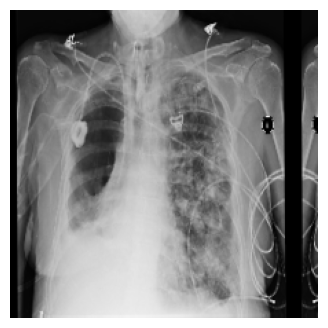

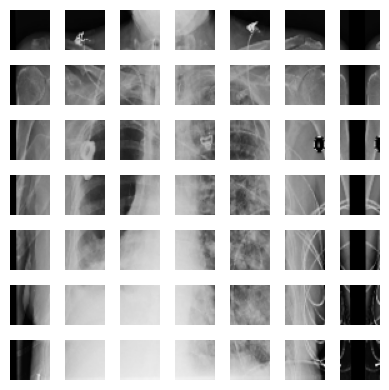

In [10]:
for image_batch, label_batch in train_generator:
    # Take one batch from the generator
    image = image_batch[0]  # Take the first image of the batch
    break  # We only need one batch, so break after the first iteration

# Define image size and patch size
image_size = 224
patch_size = 32  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2

# Display the original image
plt.figure(figsize=(4, 4))
plt.imshow(image)
plt.axis("off")
plt.show()

# Convert the image tensor to add the batch dimension and resize if necessary
image_tensor = tf.expand_dims(image, 0)  # Add batch dimension

# Create patches using the Patches layer
patches_layer = Patches(patch_size)
patches = patches_layer(image_tensor)

patches_numpy = patches.numpy()
if np.max(patches_numpy) <= 1.0:
    patches_numpy *= 255  # Scale the pixel values to [0, 255] if they are in [0, 1]
patches_numpy = patches_numpy.astype('uint8')  # Convert to uint8

# Display the patches
n = int(np.sqrt(num_patches))
plt.figure(figsize=(4, 4))
for i in range(n * n):
    ax = plt.subplot(n, n, i + 1)
    patch_img = patches_numpy[0, i].reshape(patch_size, patch_size, 3)
    plt.imshow(patch_img)
    plt.axis("off")
plt.tight_layout()
plt.show()


In [11]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

In [12]:
# Number of patches and the dimension for projecting patches
num_patches = (image_size // patch_size) ** 2
projection_dim = 64

# Instantiate the PatchEncoder layer
patch_encoder = PatchEncoder(num_patches=num_patches, projection_dim=projection_dim)

# Assume that `patches` is obtained from the Patches layer
# Here, patches.shape should be (batch_size, num_patches, patch_features)
encoded_patches = patch_encoder(patches)

# Now, `encoded_patches` should have the shape (batch_size, num_patches, projection_dim)
input_shape = (224, 224, 3)  # Assuming you are working with 224x224 RGB images
patch_size = 32              # Size of the patches to be extract from the input images
num_patches = (224 // patch_size) ** 2  # Number of patches per image
projection_dim = 64          # Size of the dense embedding for patches
num_heads = 4                # Number of attention heads
transformer_units = [
    projection_dim * 2,      # Size of the transformer layers
    projection_dim,
]
transformer_layers = 8       # Number of transformer layers
mlp_head_units = [2048, 1024]  # Hidden units in the MLP heads
num_classes = len(parser.labels)  # Assuming 'parser.labels' contains your target classes
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    directory='./archive/sample/sample/images',
    x_col="Id",
    y_col="Label",
    batch_size=32,  # Consistent with training batch size for simplicity
    target_size=(224, 224),
    class_mode='categorical')


Found 450 validated image filenames belonging to 15 classes.


In [13]:
def create_vit_classifier():
    inputs = Input(shape=input_shape)
    
    # Create patches.
    patches = Patches(patch_size)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = Flatten()(representation)
    representation = Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs with sigmoid activation function for multi-label classification.
    logits = Dense(num_classes, activation='sigmoid')(features)
    
    # Create the Keras model.
    model = Model(inputs=inputs, outputs=logits)
    return model

In [31]:
batch_size = 32
learning_rate = 1e-4
weight_decay = 1e-6
num_epochs = 10  # For real training, you might want to use a larger number.
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, weight_decay=weight_decay)


In [35]:
def run_experiment(model):
    # Choose an optimizer
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )
    # Compile the model
    model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[
        keras.metrics.BinaryAccuracy(name="accuracy"),
        keras.metrics.AUC(name="auc"),
        keras.metrics.TopKCategoricalAccuracy(k=5, name="top-5-accuracy")  # Assuming it makes sense in your context
    ]
    )

    checkpoint_filepath = "/tmp/checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    # Train the model
    history = model.fit(
        train_generator,
        epochs=num_epochs,
        validation_data=validation_generator,
        callbacks=[checkpoint_callback]
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, _, top_5_accuracy = model.evaluate(test_generator)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

In [25]:
# Set these variables as per your data and training configuration
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 56s 566ms/step - accuracy: 0.8325 - auc: 0.6622 - loss: 0.4678 - val_accuracy: 0.9076 - val_auc: 0.7914 - val_loss: 0.2624
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 39s 539ms/step - accuracy: 0.8968 - auc: 0.7153 - loss: 0.3090 - val_accuracy: 0.9123 - val_auc: 0.8107 - val_loss: 0.2597
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 38s 524ms/step - accuracy: 0.9077 - auc: 0.7505 - loss: 0.2738 - val_accuracy: 0.9101 - val_auc: 0.8158 - val_loss: 0.2577
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 39s 530ms/step - accuracy: 0.9039 - auc: 0.7413 - loss: 0.2817 - val_accuracy: 0.9113 - val_auc: 0.8147 - val_loss: 0.2696
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 39s 532ms/step - accuracy: 0.9066 - auc: 0.7499 - loss: 0.2749 - val_accuracy: 0.9075 - val_auc: 0.8173 - val_loss: 0.2680
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 40s 549ms/step - accuracy: 0.9053 - auc: 0.7566 - loss: 0.2740 - val_accuracy: 0.9051 - val_auc: 0.8129 - val_loss: 0.2567
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━

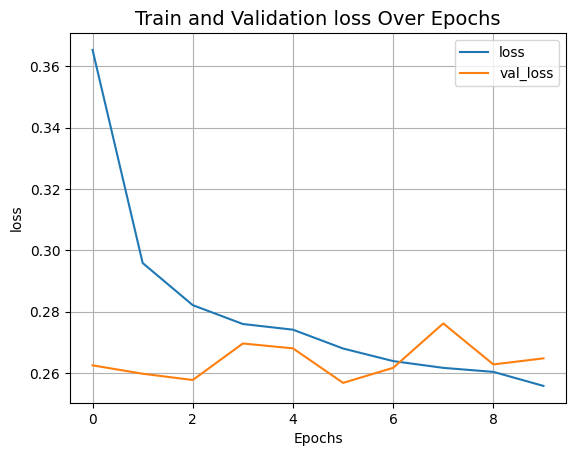

KeyError: 'top-5-accuracy'

In [89]:
def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
plot_history("top-5-accuracy")


In [33]:
def create_cnn_classifier():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(num_classes, activation='sigmoid')
    ])
    return model

In [36]:
cnn_classifier = create_cnn_classifier()
history_cnn = run_experiment(cnn_classifier)

Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 70s 971ms/step - accuracy: 0.8920 - auc: 0.7533 - loss: 0.3035 - top-5-accuracy: 0.7745 - val_accuracy: 0.9070 - val_auc: 0.7988 - val_loss: 0.2566 - val_top-5-accuracy: 0.7916
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.9121 - auc: 0.7973 - loss: 0.2499 - top-5-accuracy: 0.8003 - val_accuracy: 0.9063 - val_auc: 0.7919 - val_loss: 0.2575 - val_top-5-accuracy: 0.7694
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9123 - auc: 0.8136 - loss: 0.2412 - top-5-accuracy: 0.8046 - val_accuracy: 0.9138 - val_auc: 0.8037 - val_loss: 0.2499 - val_top-5-accuracy: 0.8049
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9172 - auc: 0.8182 - loss: 0.2370 - top-5-accuracy: 0.8013 - val_accuracy: 0.9081 - val_auc: 0.8007 - val_loss: 0.2543 - val_top-5-accuracy: 0.8093
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.9100 - auc: 0.8054 - loss: 0.2504 - top-5-accuracy: 0.7999 - val_accuracy: 0.9122 - v

In [86]:
def block(x, filters, strides=1):
    identity = x
    x = Conv2D(filters, 3, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, 3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    if strides != 1 or identity.shape[-1] != filters:
        identity = Conv2D(filters, 1, strides=strides, padding='same')(identity)
        identity = BatchNormalization()(identity)
    
    x += identity
    x = Activation('relu')(x)
    return x

In [87]:
def create_resnet():
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (7, 7), strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    x = block(x, 64)
    x = block(x, 64)
    x = block(x, 64)

    x = block(x, 128, 2)
    x = block(x, 128)
    x = block(x, 128)
    x = block(x, 128)

    x = block(x, 256, 2)
    x = block(x, 256)
    x = block(x, 256)
    x = block(x, 256)
    x = block(x, 256)
    x = block(x, 256)

    x = block(x, 512, 2)
    x = block(x, 512)
    x = block(x, 512)
    
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    return model

In [88]:
resnet = create_resnet()
history_resnet = run_experiment(resnet)

Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 237s 3s/step - accuracy: 0.8293 - auc: 0.6843 - loss: 0.3932 - top-5-accuracy: 0.6010 - val_accuracy: 0.7322 - val_auc: 0.6630 - val_loss: 0.4423 - val_top-5-accuracy: 0.3459
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 255s 4s/step - accuracy: 0.9127 - auc: 0.8193 - loss: 0.2396 - top-5-accuracy: 0.8086 - val_accuracy: 0.8213 - val_auc: 0.6233 - val_loss: 0.4190 - val_top-5-accuracy: 0.2860
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 277s 4s/step - accuracy: 0.9168 - auc: 0.8257 - loss: 0.2346 - top-5-accuracy: 0.8038 - val_accuracy: 0.8671 - val_auc: 0.6225 - val_loss: 0.3642 - val_top-5-accuracy: 0.3282
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 312s 5s/step - accuracy: 0.9162 - auc: 0.8297 - loss: 0.2352 - top-5-accuracy: 0.8087 - val_accuracy: 0.8965 - val_auc: 0.6929 - val_loss: 0.3192 - val_top-5-accuracy: 0.6541
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 286s 4s/step - accuracy: 0.9181 - auc: 0.8347 - loss: 0.2300 - top-5-accuracy: 0.8260 - val_accuracy: 0.9017 -